# Example 4: Classification

## Classification formulation

Let's then treat the problem as a classification problem (output dimension = 2, CrossEntropy loss). 

Create the two moon datatset

torch.Size([1000, 2])
torch.Size([1000])


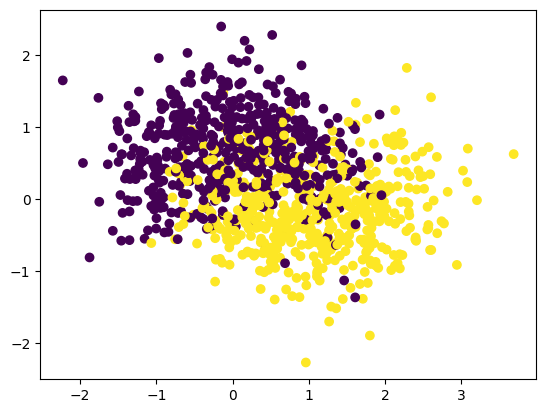

In [1]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.5, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.5, random_state=None)

dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

print(dataset['train_input'].shape)
print(dataset['train_label'].shape)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:].cpu().detach().numpy())

### Train KAN

In [2]:
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

args_dict = {
    'grid': 3,
    #'grid': 10,
    'k': 3,
    'seed': 2024,
    'base_fun': "zero",
    'sp_trainable': False,
    'sb_trainable': False,
    'affine_trainable': False,
    'update_grid': False,
    #'base_fun': ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs'],
    #'spline_noise_scale': 0.1,
    'mode': 'default',
    'init_mode': 'default',
    #'init_mode': 'xavier_in_out',
}
args = Args(**args_dict)

model = KAN(
    #width=[2,3,4,3,2], 
    width=[2,2,2,2,2], 
    #width=[2,2,2,2,2,2,2,2,2,2,2], 
    device=device,
    #width=width, device=device,
    grid=args.grid, k=args.k, seed=args.seed,
    sp_trainable=args.sp_trainable, sb_trainable=args.sb_trainable, affine_trainable=args.affine_trainable,
    base_fun=args.base_fun,
    #noise_scale=args.spline_noise_scale,
    mode=args.mode,
    init_mode=args.init_mode,
    #ckpt_path=ckpt_folder
    )

checkpoint directory created: ./model
saving model version 0.0


In [3]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

results = model.fit(
    dataset, 
    opt="LBFGS", 
    steps=20, 
    metrics=(train_acc, test_acc), 
    loss_fn=torch.nn.CrossEntropyLoss(),
    update_grid=args.update_grid
    );

| train_loss: 5.80e-01 | test_loss: 6.47e-01 | reg: 2.78e+01 | : 100%|█| 20/20 [00:15<00:00,  1.28it

saving model version 0.1


In [4]:
from sklearn.linear_model import SGDClassifier

model.eval()
model(dataset['test_input'])
targets = dataset['test_label'].cpu().detach().numpy()

classifiers = []
for postacts in model.spline_postacts:
    postacts_np = postacts.cpu().detach().numpy()
    postacts_np = postacts_np.reshape(postacts_np.shape[0], -1)
    print(postacts_np.shape)
    classifier = SGDClassifier(penalty=None, loss="log_loss", learning_rate="constant", eta0=0.01)
    classifier.fit(postacts_np, targets)
    classifiers.append(classifier)
    score = classifier.score(postacts_np, targets)
    print(score) 
    #print(classifier.score(postacts_np, targets))

(1000, 4)
0.816
(1000, 4)
0.82
(1000, 4)
0.83
(1000, 4)
0.822


In [5]:
print

<function print>

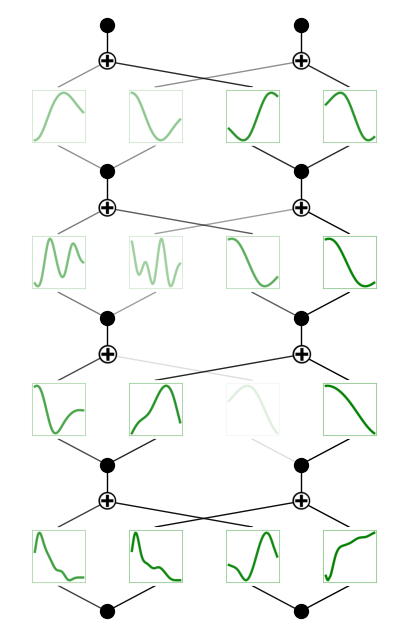

In [6]:
model.plot()

Plot Predictions
[1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 0
 1 0 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0
 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 0
 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1
 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1
 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 1 0 1
 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1
 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0
 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1
 0 0 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0
 0 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1
 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 0
 1 0 0 0

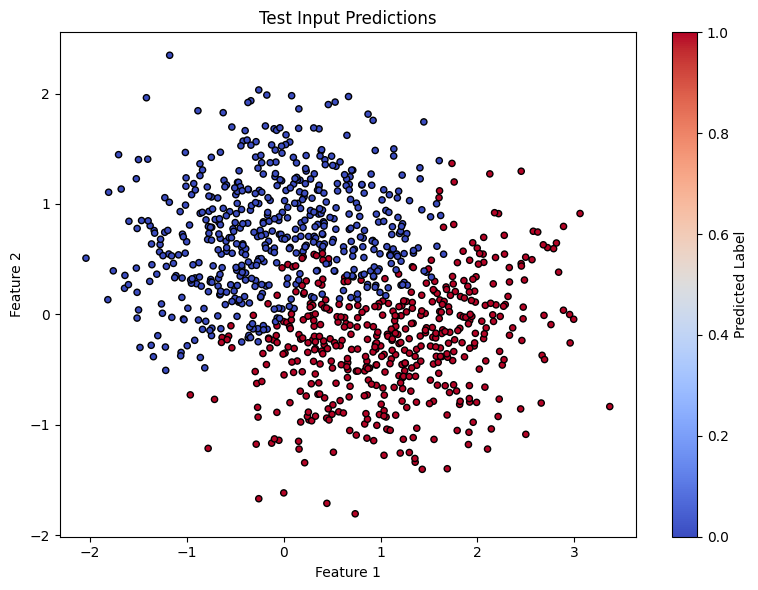

In [7]:
def plot_predictions(model, dataset, title):
    print("Plot Predictions")
    # Make predictions on the test input
    with torch.no_grad():  # Disable gradient calculation for inference
        predictions = model(dataset['test_input'])  # Get model predictions
        predicted_labels = torch.argmax(predictions, dim=1).cpu().detach().numpy()  # Use argmax for class labels
        print(predicted_labels)

    # Create a scatter plot of the test input colored by the predicted labels
    plt.figure(figsize=(8, 6))
    plt.scatter(dataset['test_input'][:, 0].cpu().detach().numpy(), 
                dataset['test_input'][:, 1].cpu().detach().numpy(), 
                c=predicted_labels, cmap='coolwarm', edgecolor='k', s=20)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Predicted Label')
    plt.tight_layout()
    #mlflow.log_figure(plt.gcf(), "test_input_predictions.png")
    return plt.gcf()

plot_predictions(model, dataset, "Test Input Predictions")
plt.show()

act (1000, 2, 2)
act sum (1000, 2, 1)
act (1000, 2, 2)
act sum (1000, 2, 1)
act (1000, 2, 2)
act sum (1000, 2, 1)
act (1000, 2, 2)
act sum (1000, 2, 1)


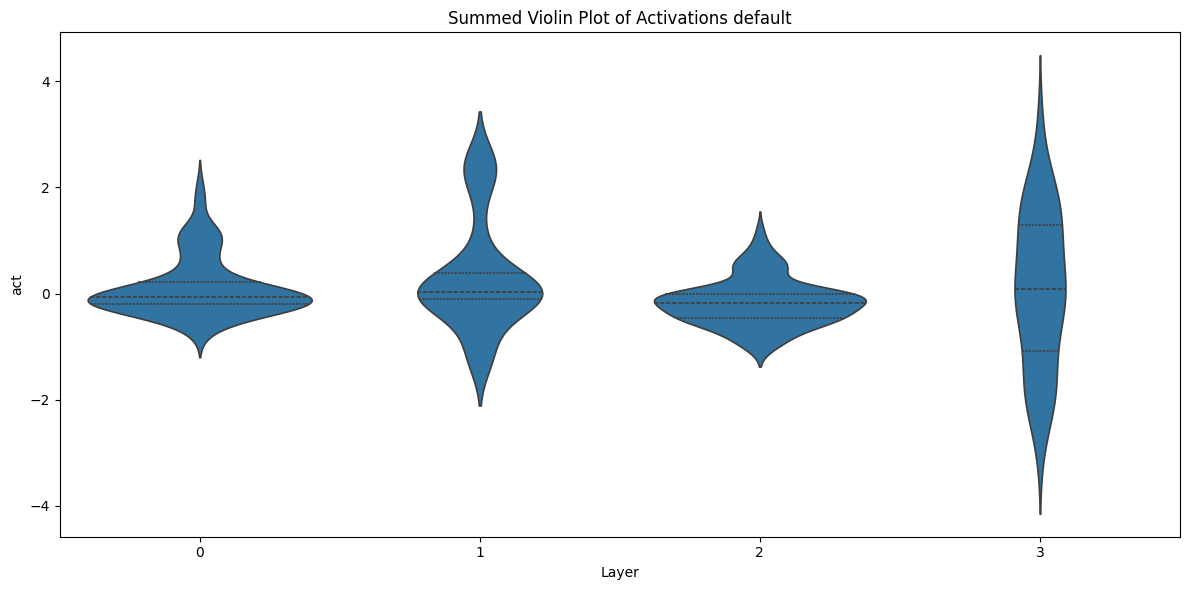

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_summed_violins(model, title, mode="act", sample_size=100):
    data = []
    for layer_index, (act_fun, acts, preacts, postacts, postsplines) in enumerate(zip(model.act_fun, model.acts, model.spline_preacts, model.spline_postacts, model.spline_postsplines)):
        
        coef = act_fun.coef

        dist_np = None  # Changed from acts_np to dist_np
        if mode == "coef":
            dist_np = coef.cpu().detach().numpy()
            print("act", dist_np.shape)
            dist_np = dist_np.sum(axis=2, keepdims=True)    
            print("act sum",dist_np.shape)
        elif mode == "act":
            dist_np = postacts.cpu().detach().numpy()
            print("act", dist_np.shape)
            dist_np = dist_np.sum(axis=2, keepdims=True)    
            print("act sum",dist_np.shape)
        elif mode == "grad":
            dist_np = coef.grad.cpu().detach().numpy()




        # Ensure dist_np is a 1D array
        dist_np = dist_np.flatten()

        # Sample a subset of activations if there are more than sample_size
        if len(dist_np) > sample_size:
            sampled_acts = np.random.choice(dist_np, sample_size, replace=False)
        else:
            sampled_acts = dist_np  # Use all if less than sample_size
        
        # Append layer index and sampled activations to the data list
        data.extend([(layer_index, act) for act in sampled_acts])

    # Convert the data into a DataFrame
    df = pd.DataFrame(data, columns=['Layer', 'Activation'])

    plt.figure(figsize=(12, 6))

    # Create a violin plot
    sns.violinplot(data=df, x="Layer", y="Activation", inner="quart")

    # Adding labels and title
    plt.title(title)
    plt.xlabel('Layer')
    plt.ylabel(f'{mode}')
    plt.tight_layout()

    # Show plot
    plt.show()
    return plt.gcf()

title = f"Summed Violin Plot of Activations {args.init_mode}"
plot_summed_violins(model, title, mode="act", sample_size=100)

act (2, 2, 6)
act sum (2, 2, 1)
act (2, 2, 6)
act sum (2, 2, 1)
act (2, 2, 6)
act sum (2, 2, 1)
act (2, 2, 6)
act sum (2, 2, 1)


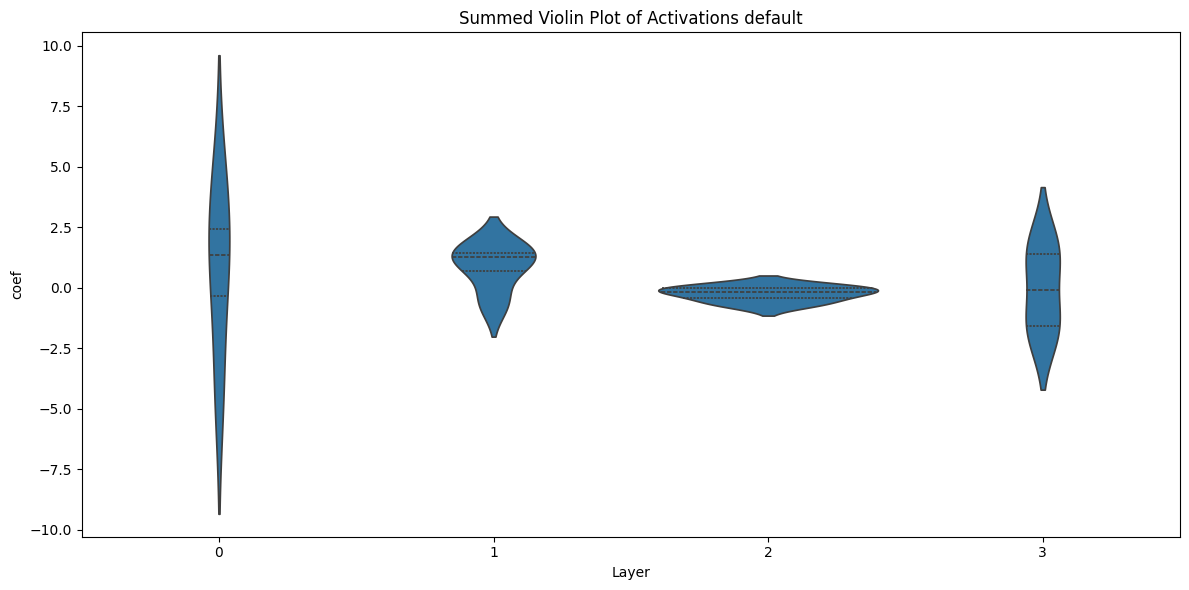

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
title = f"Summed Violin Plot of Activations {args.init_mode}"
plot_summed_violins(model, title, mode="coef", sample_size=100)

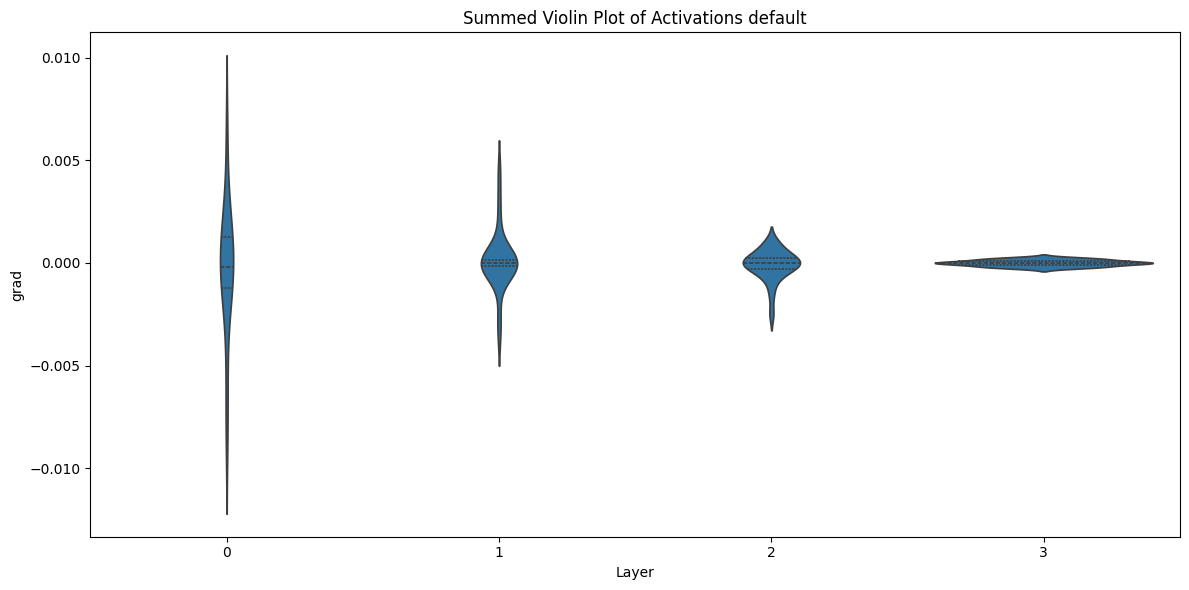

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
title = f"Summed Violin Plot of Activations {args.init_mode}"
plot_summed_violins(model, title, mode="grad", sample_size=100)